#### Import Libraries

In [ ]:
# ===== Auto Reload =====
%load_ext autoreload
%autoreload 2

# ===== Standard Libraries =====
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import os
import re

# ===== PyTorch =====
import torch
import torch.nn as nn
from torchdiffeq import odeint

# torchdiffeq 버전 확인
import torchdiffeq
print(f"torchdiffeq version: {torchdiffeq.__version__}")
print("")

# ===== Check Installation =====
print("="*50)
print("Environment Check")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("="*50)
print("")


# ===== Your Custom Module =====
# Import from battery_ode_wrapper
from battery_ode_wrapper_joint import*
from utils import*

print("="*50)
print("✓ All modules loaded!")
print("="*50)


torchdiffeq version: 0.2.5

Environment Check
PyTorch version: 2.5.1
CUDA device: NVIDIA RTX 3500 Ada Generation Laptop GPU
CUDA available: True

✓ All modules loaded!


#### Data Import

In [2]:
# MATLAB 데이터 디렉토리 경로
data_dir = r"C:\Users\ljw76\Documents\MATLAB\LFP_SAFT\data\learning_data"

# ===== 온도 필터 설정 =====
target_temps = [25]  # 원하는 온도 리스트 (예: [25, 35] 또는 [] 이면 모든 온도)

# 디렉토리 내 모든 .mat 파일 목록 가져오기
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files:")
for file in mat_files:
    print(f"  - {file}")

# 모든 파일 로드
print(f"\nLoading files with temperature filter: {target_temps if target_temps else 'All'}")
all_loaded_data = {}

for i, file in enumerate(mat_files):
    file_path = os.path.join(data_dir, file)
    print(f"Loading {i+1}/{len(mat_files)}: {file}")
    
    try:
        mat_data = scipy.io.loadmat(file_path)
        
        # 온도 추출 (파일명에서, 대문자 C만 찾기)
        temp_match = re.search(r'_(\d+)C_', file)
        file_temp = int(temp_match.group(1)) if temp_match else None
        
        # 온도 필터링
        if target_temps and (file_temp is None or file_temp not in target_temps):
            print(f"  ⚠ Skipped (temp: {file_temp}°C)")
            continue
        
        # 파일명에서 확장자 제거하여 키로 사용
        file_key = file.replace('.mat', '')
        
        # 메타데이터 키 제외한 실제 데이터만 저장
        data_keys = [key for key in mat_data.keys() if not key.startswith('__')]
        all_loaded_data[file_key] = {}
        
        for key in data_keys:
            all_loaded_data[file_key][key] = mat_data[key]
        
        print(f"  ✓ Loaded (temp: {file_temp}°C) - {len(data_keys)} data keys: {data_keys}")
        
    except Exception as e:
        print(f"  ✗ Failed to load {file}: {e}")

print(f"\nAll files loaded!")
print(f"Successfully loaded {len(all_loaded_data)} files:")
for file_key, data_dict in all_loaded_data.items():
    print(f"  {file_key}: {list(data_dict.keys())}")

# 첫 번째 파일의 데이터 구조 상세 확인
if all_loaded_data:
    first_file_key = list(all_loaded_data.keys())[0]
    first_data_key = list(all_loaded_data[first_file_key].keys())[0]
    sample_data = all_loaded_data[first_file_key][first_data_key]

    print(f"\nSample data structure from {first_file_key}[{first_data_key}]:")
    print(f"  Shape: {sample_data.shape}")
    print(f"  Type: {type(sample_data)}")
    if hasattr(sample_data, 'dtype'):
        print(f"  Dtype: {sample_data.dtype}")
        if hasattr(sample_data.dtype, 'names') and sample_data.dtype.names:
            print(f"  Field names: {sample_data.dtype.names}")



Found 151 .mat files:
  - gitt_restonly_25C_SOC_10.mat
  - gitt_restonly_25C_SOC_100.mat
  - gitt_restonly_25C_SOC_11.mat
  - gitt_restonly_25C_SOC_12.mat
  - gitt_restonly_25C_SOC_13.mat
  - gitt_restonly_25C_SOC_14.mat
  - gitt_restonly_25C_SOC_15.mat
  - gitt_restonly_25C_SOC_16.mat
  - gitt_restonly_25C_SOC_17.mat
  - gitt_restonly_25C_SOC_18.mat
  - gitt_restonly_25C_SOC_19.mat
  - gitt_restonly_25C_SOC_2.mat
  - gitt_restonly_25C_SOC_20.mat
  - gitt_restonly_25C_SOC_21.mat
  - gitt_restonly_25C_SOC_22.mat
  - gitt_restonly_25C_SOC_23.mat
  - gitt_restonly_25C_SOC_25.mat
  - gitt_restonly_25C_SOC_26.mat
  - gitt_restonly_25C_SOC_27.mat
  - gitt_restonly_25C_SOC_28.mat
  - gitt_restonly_25C_SOC_29.mat
  - gitt_restonly_25C_SOC_3.mat
  - gitt_restonly_25C_SOC_30.mat
  - gitt_restonly_25C_SOC_31.mat
  - gitt_restonly_25C_SOC_32.mat
  - gitt_restonly_25C_SOC_33.mat
  - gitt_restonly_25C_SOC_34.mat
  - gitt_restonly_25C_SOC_35.mat
  - gitt_restonly_25C_SOC_36.mat
  - gitt_restonly_25C_

#### Convert Struct to DataFrame

In [3]:
# ===== Key 선택 =====
target_keys = ["time", "Vref", "Vspme", "current", "temperature", "c_s_n_bulk", "soc_n", "ocp"]

# ===== 모든 파일 처리 =====
extracted_data = {}  # Dictionary로 저장

excluded_target = []
excluded_data = {}
# extracted_data는 excluded_target에 들어있지 않은 것만, excluded_data는 target에 들어있는 것만 저장하도록 아래 for문 수정

print("="*60)
print("Converting all structs to DataFrames")
print("="*60)

for file_key, data_dict in all_loaded_data.items():
    print(f"\nProcessing: {file_key}")
    
    # struct 추출 (첫 번째 key)
    struct_key = list(data_dict.keys())[0]
    struct_data = data_dict[struct_key]
    
    # DataFrame 변환
    df = struct2df(struct_data, selected_keys=target_keys)

    # 저장: excluded_target 리스트에 있으면 excluded_data에, 아니면 extracted_data에
    if file_key in excluded_target:
        excluded_data[file_key] = df
        print(f"  ✓ DataFrame created (EXCLUDED): {df.shape}")
    else:
        extracted_data[file_key] = df
        print(f"  ✓ DataFrame created: {df.shape}")
    print(f"  Columns: {list(df.columns)}")

print("\n" + "="*60)
print(f"✓ Total {len(extracted_data)} DataFrames created!")
print(f"✓ Total {len(excluded_data)} EXCLUDED DataFrames created!")
print("="*60)

# 요약
for name, df in extracted_data.items():
    print(f"  {name}: {df.shape}")

for name, df in excluded_data.items():
    print(f"  (EXCLUDED) {name}: {df.shape}")
# extracted_data는 excluded_target에 들어있지 않은 것만 들어가게끔 for문에서 처리 (아래 for문 참고!)



Converting all structs to DataFrames

Processing: gitt_restonly_25C_SOC_10
Available keys in MATLAB struct:
   1. time
   2. current
   3. temperature
   4. Vout
   5. Ve
   6. Vcond
   7. eta_p
   8. eta_n
   9. Un
  10. Up
  11. ocp
  12. soc_n
  13. soc_p
  14. c_s_p_surf
  15. c_s_n_surf
  16. c_s_p_bulk
  17. c_s_n_bulk
  18. i0p
  19. k_cs
  20. alpha_cs
  21. tau_cs
  22. c_s_p_surf_tilde
  23. Dsn_eff
  24. Dsp_eff
  25. Vspme
  26. Vref
Total: 26 keys

Selected keys:
  1. time ✓
  2. Vref ✓
  3. Vspme ✓
  4. current ✓
  5. temperature ✓
  6. c_s_n_bulk ✓
  7. soc_n ✓
  8. ocp ✓

Extracting data:
------------------------------------------------------------
  ✓ time                : shape (3601, 1)       → 3601 points
  ✓ Vref                : shape (3601, 1)       → 3601 points
  ✓ Vspme               : shape (3601, 1)       → 3601 points
  ✓ current             : shape (3601, 1)       → 3601 points
  ✓ temperature         : shape (3601, 1)       → 3601 points
  ✓ c_s_n_bulk   

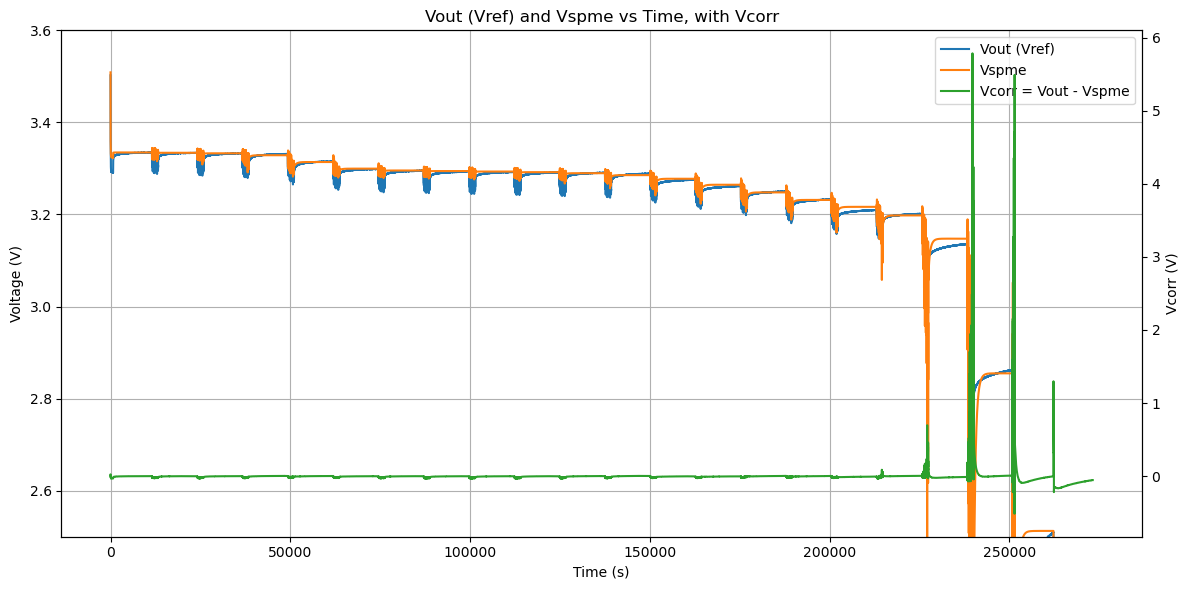

In [4]:
df = extracted_data['udds2_1c_rest_25C_struct']

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis: Vout (Vref) and Vspme
ax1.plot(df['time'], df['Vref'], label='Vout (Vref)', color='C0')
ax1.plot(df['time'], df['Vspme'], label='Vspme', color='C1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim([2.5, 3.6])
ax1.set_title('Vout (Vref) and Vspme vs Time, with Vcorr')
ax1.grid(True)

# Right y-axis: Vcorr = Vout - Vspme
ax2 = ax1.twinx()
Vcorr = df['Vref'] - df['Vspme']
ax2.plot(df['time'], Vcorr, label='Vcorr = Vout - Vspme', color='C2')
ax2.set_ylabel('Vcorr (V)')
# Optionally, you may want to set Vcorr y-limits, e.g.:
# ax2.set_ylim([Vcorr.min(), Vcorr.max()])

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()




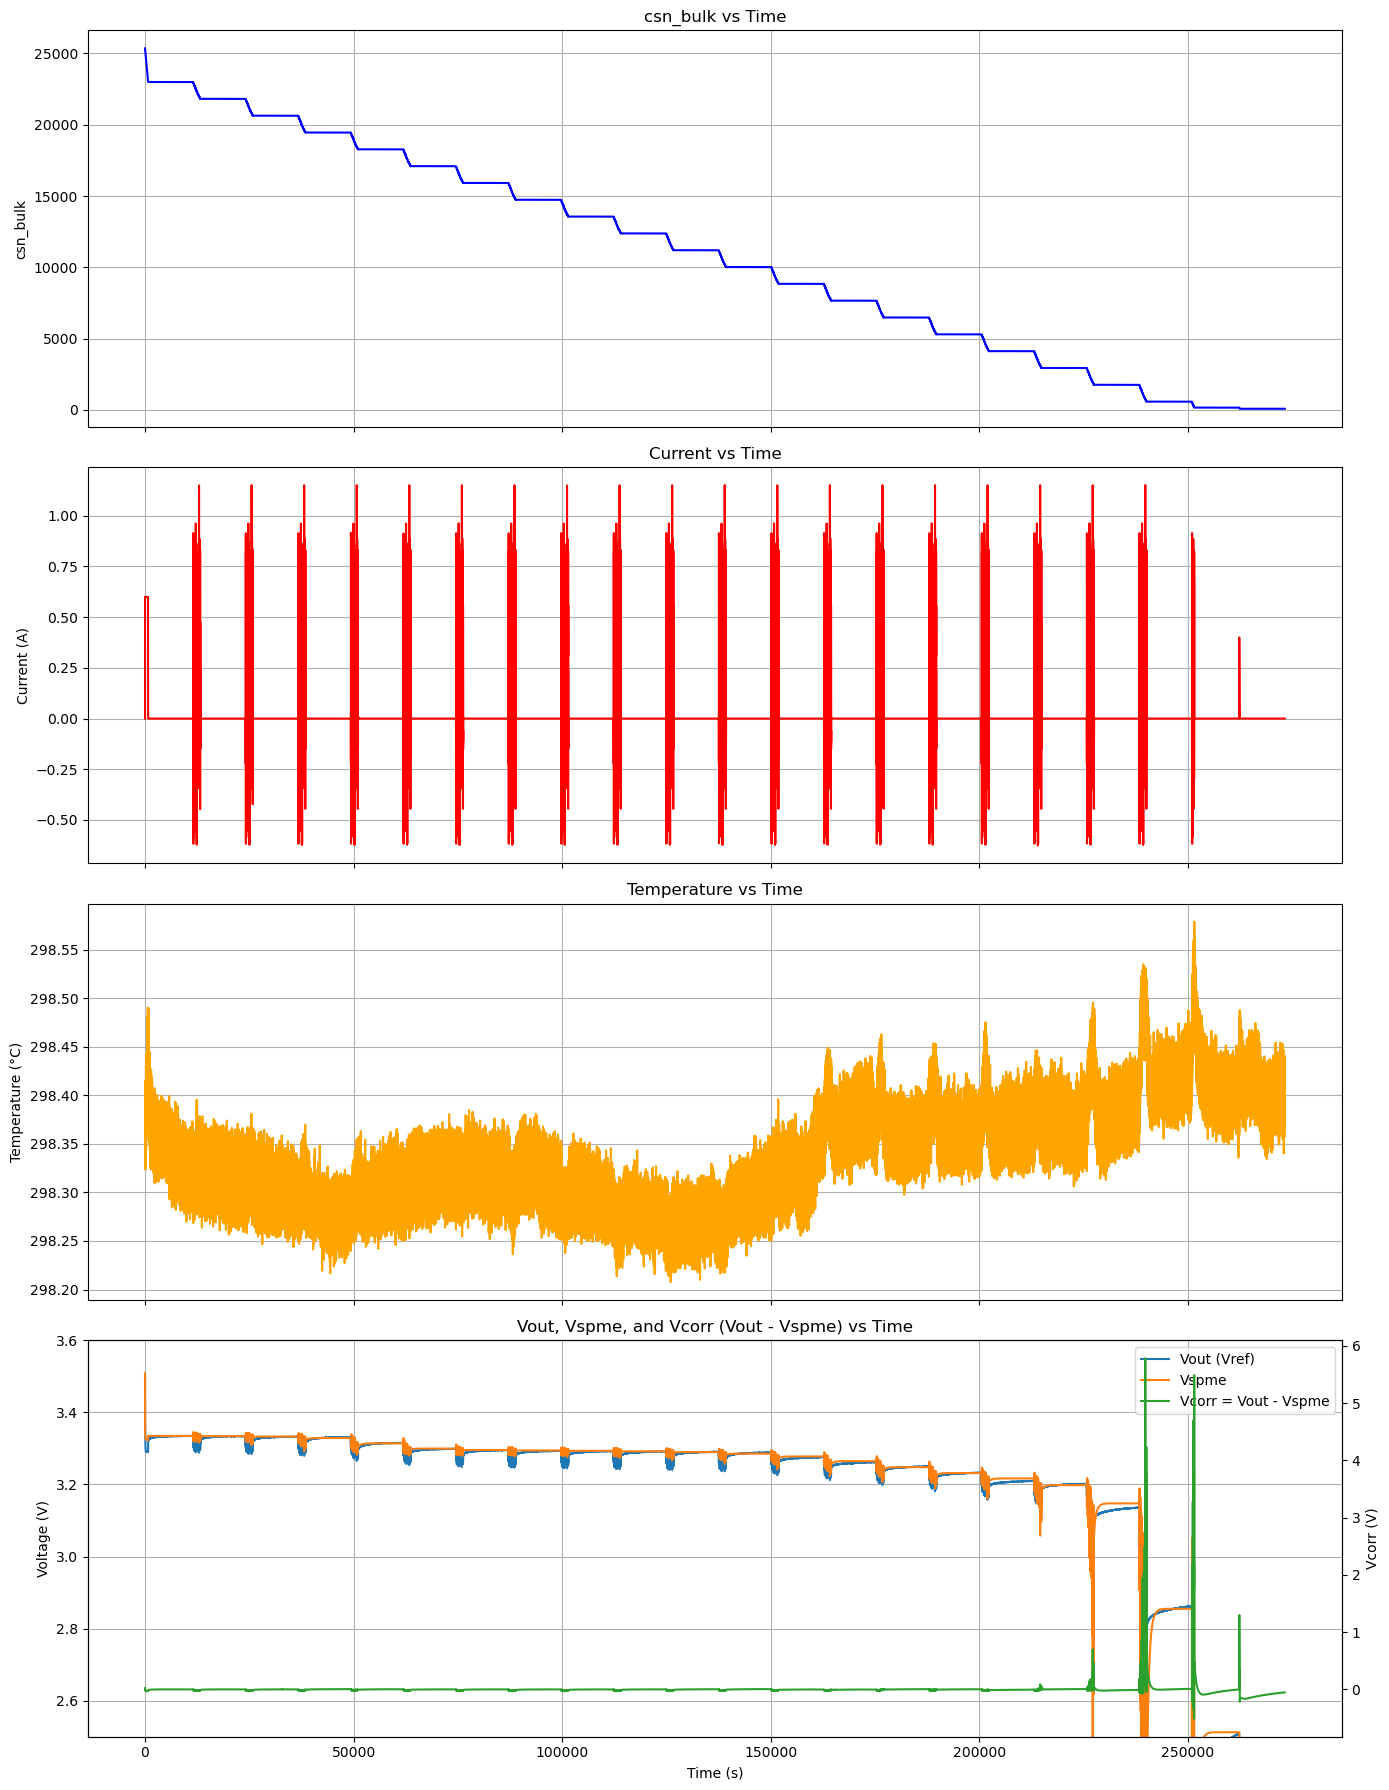

In [5]:
# Assume df_sampled is already defined just as in the next cell (sampled first 10% of data)
df_vis = df

fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# 1. csn_bulk
axs[0].plot(df_vis["time"], df_vis["c_s_n_bulk"], color="blue")
axs[0].set_ylabel("csn_bulk")
axs[0].set_title("csn_bulk vs Time")
axs[0].grid(True)

# 2. I (Current)
axs[1].plot(df_vis["time"], df_vis["current"], color="red")
axs[1].set_ylabel("Current (A)")
axs[1].set_title("Current vs Time")
axs[1].grid(True)

# 3. Temperature (T)
axs[2].plot(df_vis["time"], df_vis["temperature"], color="orange")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Temperature vs Time")
axs[2].grid(True)

# 4. Vout, Vspme (left) and Vcorr (right)
ax4 = axs[3]
ax4.plot(df_vis["time"], df_vis["Vref"], label="Vout (Vref)", color="C0")
ax4.plot(df_vis["time"], df_vis["Vspme"], label="Vspme", color="C1")
ax4.set_ylabel("Voltage (V)")
ax4.set_title("Vout, Vspme, and Vcorr (Vout - Vspme) vs Time")
ax4.set_ylim([2.5, 3.6])  # Set voltage axis limits as requested
ax4.grid(True)

ax4r = ax4.twinx()
Vcorr = df_vis["Vref"] - df_vis["Vspme"]
ax4r.plot(df_vis["time"], Vcorr, label="Vcorr = Vout - Vspme", color="C2")
ax4r.set_ylabel("Vcorr (V)")

# Combine legends from both y-axes
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4r.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

axs[3].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()



#### Data Pre-Processing

In [6]:
# 'soc_n' 값이 0.96 ~ 0.12 (96% ~ 12%) 사이인 데이터만 target_data에 저장
# target_data를 리스트(list)로 저장 (DataFrame만 담김, key는 저장하지 않음)
drivingonly_keywords = ['drivingonly']
norest_keywords = ['norest']
rest_keywords = ['restonly']


# '정확히 들어있는' key만 골라야 한다.
# 즉, partial match는 안 되고, 부분 단어 단위(예: 'rest')가 key 중 'norest' 등에도 들어가 있으면 제외해야 한다.
# → "정확히 포함" = 'rest'라는 단어가 key에 있는데 앞뒤에 다른 알파벳(예: norest, unrest) 등이 붙어있으면 "rest"만 들어간 것이 아님 → 패턴 분리 필요
# 가장 명확한 건 '_'(언더바) 등으로 단어 구분된 구조에서 "단어 경계" 기준 매칭이다.
# 정규표현식으로 '[^a-zA-Z0-9]' + word + '[^a-zA-Z0-9]' 또는 key.split('_') 등으로 토큰화하여 비교


drivingonly_list = extract_data(extracted_data, drivingonly_keywords, soc_lb=0.11, soc_ub=0.96)
norest_list = extract_data(extracted_data, norest_keywords, soc_lb=0.11, soc_ub=0.96)
rest_list = extract_data(extracted_data, rest_keywords, soc_lb=0.11, soc_ub=0.96)


drivingonly_list = remove_duplicates(drivingonly_list)
norest_list = remove_duplicates(norest_list)
rest_list = remove_duplicates(rest_list)

rest_list_smooth = smooth_Vcorr(rest_list, 201) # de-noise data after downsampling

# rest_list_ds = downsample_df(rest_list_smooth, downsample_rate=1)   

# drivingonly_list_split = split_df(drivingonly_list, window_minutes=20, time_col='time', random_seed=42)
norest_list_split = split_df(norest_list, window_minutes=20, time_col='time', random_seed=42)
rest_list_split = split_df(rest_list_smooth, window_minutes=20, time_col='time', random_seed=42)

drivingonly_dict_list = df2dict(drivingonly_list)
norest_dict_list = df2dict(norest_list_split)
rest_dict_list = df2dict(rest_list_split)


# 80:20 split for training and test
drivingonly_dict_training, drivingonly_dict_test = split_train_test(drivingonly_dict_list, 1.0)
mid_idx = len(drivingonly_dict_training) // 2
drivingonly_dict_test = [drivingonly_dict_training.pop(mid_idx)]
# print(f"drivingonly_dict_training: {len(drivingonly_dict_training)}")
# print(f"drivingonly_dict_test: {len(drivingonly_dict_test)}")


norest_dict_training, norest_dict_test = split_train_test(norest_dict_list, 0.8)
rest_dict_training, rest_dict_test = split_train_test(rest_dict_list, 0.8)


training_dict_list = drivingonly_dict_training + norest_dict_training + rest_dict_training
test_dict_list = drivingonly_dict_test + norest_dict_test + rest_dict_test

# print(f"training_dict_list: {len(training_dict_list)}")
# print(f"test_dict_list: {len(test_dict_list)}")


Key: gitt_restonly_25C_SOC_10, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_100, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_11, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_12, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_13, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_14, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_15, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_16, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_17, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_18, keyword_match: False, type: <class 'pandas.core.frame.DataFrame'>
Key: gitt_restonly_25C_SOC_19

In [8]:
# ===== Joint Training =====
from battery_ode_wrapper_joint import*

num_epochs = 1000
lr = 5e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
training_batch_size = None  # Use all profiles (4) for each epoch


seed = 42 # 42 : Vcorr_k, csn_k, I_k, T_k,
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


# Call joint training with pretrained models
# head_training=False: Freeze driving/rest heads, train only gating layer
# head_training=True: Train all networks together (fine-tuning)
ode_wrapper_joint, history_joint = train_battery_neural_ode_joint(
    data_list=training_dict_list,
    num_epochs=num_epochs,
    lr=lr,
    device=device,
    verbose=True,
    training_batch_size=training_batch_size,
    method='euler',
    pretrained_driving_model_path='best_model_batch_rmse1.61mV_driving_6input.pth',
    pretrained_rest_model_path='best_model_batch_rmse0.55mV_rest_6input.pth',
    head_training=False  # False: freeze heads, train only gating layer
)



Joint Batch Training: 537 total profiles
Training batch size: 537 profiles per epoch
Profile lengths: [412, 1801, 1801, 85, 1800, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1800, 1801, 1801, 85, 1801, 1200, 1201, 1204, 1203, 1201, 1203, 1202, 1201, 1202, 1200, 1202, 1202, 1201, 1201, 1204, 1202, 1200, 1202, 1201, 1200, 1204, 1203, 1204, 1202, 1201, 1204, 1201, 1202, 1201, 1202, 1202, 1204, 1202, 1201, 1202, 1204, 1201, 1202, 1202, 1202, 1201, 1201, 1200, 1201, 1201, 1202, 1200, 1201, 1201, 1203, 1203, 1202, 1201, 1204, 1201, 1200, 1202, 1200, 1201, 1096, 1203, 1197, 1202, 1175, 1204, 1201, 1202, 1202, 1202, 1202, 1201, 1204, 1203, 1203, 1202, 1200, 1202, 1201, 1202, 1201, 1203, 1201, 1202, 1201, 1203, 1202, 1204, 1203, 1202, 1200, 1202, 1202, 1202, 1202, 1201, 1202, 1202, 1204, 1202, 1201, 1201, 1204, 1201, 1201, 1202, 1200, 1201, 1202, 1202, 1201, 1202, 1200, 1200, 1202, 1204, 1201, 1204, 1201, 1201, 1201, 1204, 1201, 1202, 1201, 1200, 1203, 1201, 1202, 1203, 1201, 1201, 1

In [9]:
# ===== Fine-tuning (Joint, head_training=True) =====

# Load joint model with fixed heads (previous result as initialization)
fine_tune_model_path = 'best_model_joint_rmse1.53mV_joint_fixedheads.pth'

# Ensure torch and others are available from previous cells
from battery_ode_wrapper_joint import *

# Re-instantiate model and load weights
ode_wrapper_joint_ft = BatteryODEWrapperJoint(device=device)
ode_wrapper_joint_ft = ode_wrapper_joint_ft.to(device)

checkpoint_ft = torch.load(fine_tune_model_path, map_location=device, weights_only=False)
if isinstance(checkpoint_ft, dict) and 'model_state_dict' in checkpoint_ft:
    ode_wrapper_joint_ft.load_state_dict(checkpoint_ft['model_state_dict'], strict=True)
    print("✅ Fine-tuning: Model loaded from 'best_model_joint_rmse1.51mV_joint_fixedheads.pth'")
else:
    ode_wrapper_joint_ft.load_state_dict(checkpoint_ft, strict=True)
    print("✅ Fine-tuning: Model loaded from 'best_model_joint_rmse1.51mV_joint_fixedheads.pth'")

ode_wrapper_joint_ft.eval()

# Fine-tune with head_training=True (full model training)
num_epochs_ft = 1000  # For example, 1000 epochs for fine-tuning (adjust as desired)
lr_ft = 2e-4         # Optionally, use smaller learning rate for fine-tuning

ode_wrapper_joint_finetuned, history_joint_finetuned = train_battery_neural_ode_joint(
    data_list=training_dict_list,
    num_epochs=num_epochs_ft,
    lr=lr_ft,
    device=device,
    verbose=True,
    training_batch_size=training_batch_size,
    method='euler',
    pretrained_driving_model_path=None,     # Not used for subsequent fine-tuning
    pretrained_rest_model_path=None,        # Not used for subsequent fine-tuning
    pretrained_joint_model=ode_wrapper_joint_ft,  # Pass the previously loaded joint model
    head_training=True  # ===> Fine-tune all heads + gating layer
)


✅ Fine-tuning: Model loaded from 'best_model_joint_rmse1.51mV_joint_fixedheads.pth'

Joint Batch Training: 537 total profiles
Training batch size: 537 profiles per epoch
Profile lengths: [412, 1801, 1801, 85, 1800, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1801, 1800, 1801, 1801, 85, 1801, 1200, 1201, 1204, 1203, 1201, 1203, 1202, 1201, 1202, 1200, 1202, 1202, 1201, 1201, 1204, 1202, 1200, 1202, 1201, 1200, 1204, 1203, 1204, 1202, 1201, 1204, 1201, 1202, 1201, 1202, 1202, 1204, 1202, 1201, 1202, 1204, 1201, 1202, 1202, 1202, 1201, 1201, 1200, 1201, 1201, 1202, 1200, 1201, 1201, 1203, 1203, 1202, 1201, 1204, 1201, 1200, 1202, 1200, 1201, 1096, 1203, 1197, 1202, 1175, 1204, 1201, 1202, 1202, 1202, 1202, 1201, 1204, 1203, 1203, 1202, 1200, 1202, 1201, 1202, 1201, 1203, 1201, 1202, 1201, 1203, 1202, 1204, 1203, 1202, 1200, 1202, 1202, 1202, 1202, 1201, 1202, 1202, 1204, 1202, 1201, 1201, 1204, 1201, 1201, 1202, 1200, 1201, 1202, 1202, 1201, 1202, 1200, 1200, 1202, 1204, 1201, 1204, 1

✅ Model loaded successfully (including gating layer from checkpoint)!
   Training info: Best RMSE = 1.06mV at epoch 461
Running inference on 132 test profiles...
Processed 50/132 profiles...
Processed 100/132 profiles...

===== Test set 전체 RMSE: 1.37 mV (0.001370 V) =====



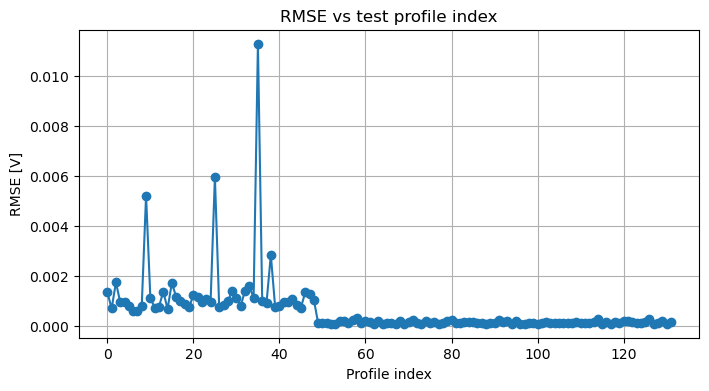

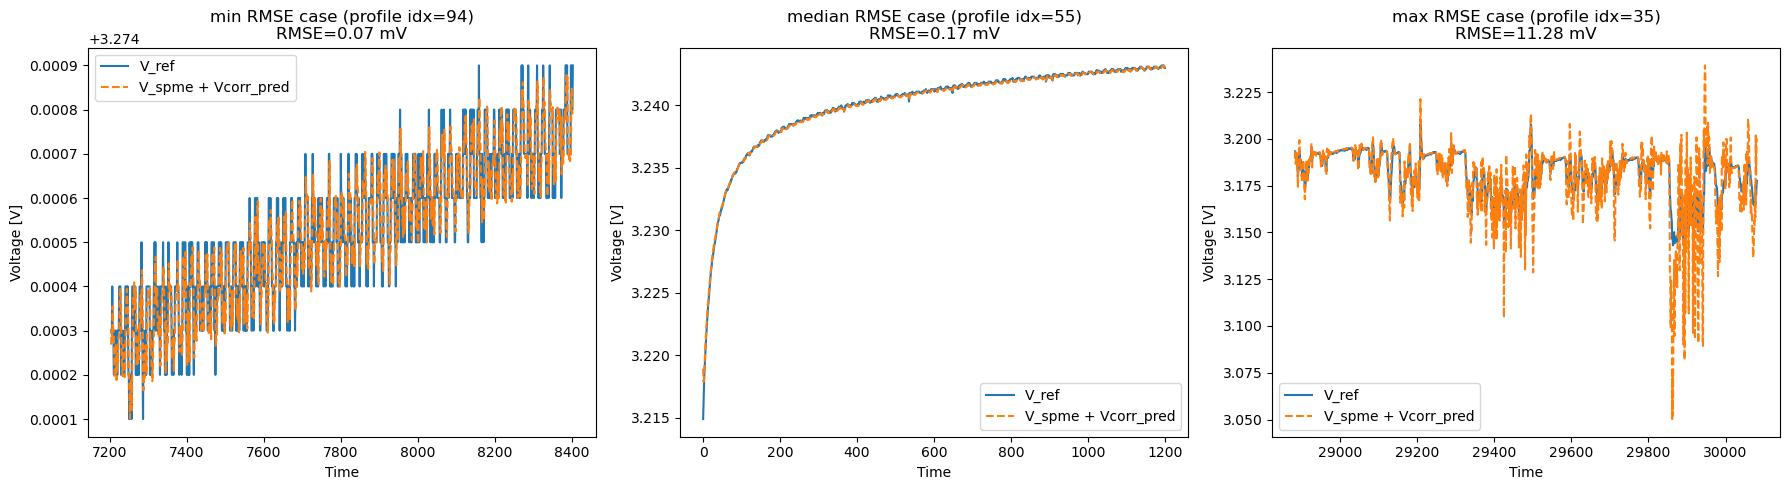

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from battery_ode_wrapper_joint import BatteryODEWrapperJoint
from torchdiffeq import odeint

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Create model instance and load the best joint model
best_model_path = 'best_model_joint_rmse1.06mV.pth'
ode_wrapper_joint = BatteryODEWrapperJoint(device=device)
ode_wrapper_joint = ode_wrapper_joint.to(device)

checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper_joint.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print("✅ Model loaded successfully (including gating layer from checkpoint)!")
    if 'training_info' in checkpoint:
        training_info = checkpoint['training_info']
        print(f"   Training info: Best RMSE = {training_info.get('best_rmse', 'N/A'):.2f}mV at epoch {training_info.get('best_epoch', 'N/A')}")
else:
    ode_wrapper_joint.load_state_dict(checkpoint, strict=True)
    print("✅ Model loaded successfully (including gating layer from checkpoint)!")

ode_wrapper_joint.eval()

# 2. Run test set and collect results
rmse_list = []
Vref_list = []
Vspme_list = []
Vcorr_pred_list = []
time_list = []

# Helper function: de-normalize Vcorr_pred
def denorm_vcorr(vcorr_norm, Y_mean, Y_std):
    return vcorr_norm * Y_std + Y_mean

# Run inference on test set
print(f"Running inference on {len(test_dict_list)} test profiles...")
for i, profile in enumerate(test_dict_list):
    with torch.no_grad():
        # Set up inputs for single profile
        inputs_dict = {
            'time': profile['time'],
            'V_ref': profile['V_ref'],
            'ocv': profile['ocv'],
            'SOC': profile['SOC'],
            'I': profile['I'],
            'T': profile['T'],
            'V_spme': profile['V_spme'],
        }
        
        ode_wrapper_joint.set_inputs(inputs_dict)
        
        # Prepare ODE solving (use normalized Vcorr target, as in training)
        t_eval = torch.tensor(profile['time'], dtype=torch.float32, device=device)
        Y_target = profile['Y']          # normalized Vcorr
        Y_mean = profile['Y_mean']       # for denormalization
        Y_std = profile['Y_std']         # for denormalization
        
        # Initial condition: use normalized Vcorr (same as training)
        Vcorr_0 = Y_target[0]
        x0 = torch.tensor([[Vcorr_0]], dtype=torch.float32, device=device)
        
        # Solve ODE
        solution = odeint(ode_wrapper_joint, x0, t_eval, method='euler')
        Vcorr_pred_norm = solution[:, 0, 0].cpu().numpy()
        
        # Denormalize Vcorr_pred to physical units
        Vcorr_pred_denorm = denorm_vcorr(Vcorr_pred_norm, Y_mean, Y_std)
        
        # Get denormalized data from profile (actual measurements)
        Vspme = np.array(profile['V_spme'])
        V_meas = np.array(profile['V_meas'])
        time = np.array(profile['time'])
        
        # Final prediction: V_pred = Vspme + Vcorr_pred_denorm
        V_pred = Vspme + Vcorr_pred_denorm

        # Store predictions back into the profile for later plotting/analysis
        profile['Vcorr_pred'] = Vcorr_pred_denorm  # denormalized prediction
        profile['Vcorr_pred_norm'] = Vcorr_pred_norm  # normalized prediction

        # Calculate RMSE: compare V_pred (denormalized) with V_meas (denormalized)
        rmse = np.sqrt(np.mean((V_pred - V_meas)**2))
        rmse_list.append(rmse)
        Vref_list.append(V_meas)  # Store actual measured values
        Vspme_list.append(Vspme)
        Vcorr_pred_list.append(Vcorr_pred_denorm)
        time_list.append(time)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i+1}/{len(test_dict_list)} profiles...")

# 1. 전체 RMSE 계산해서 프린트
global_rmse = np.sqrt(np.mean([np.mean((Vspme_list[i] + Vcorr_pred_list[i] - Vref_list[i])**2) for i in range(len(rmse_list))]))
print(f"\n===== Test set 전체 RMSE: {global_rmse*1e3:.2f} mV ({global_rmse:.6f} V) =====\n")

# 2. 전체 RMSE 계산해서 plot (RMSE vs profile index)
plt.figure(figsize=(8, 4))
plt.plot(rmse_list, marker='o')
plt.title('RMSE vs test profile index')
plt.xlabel('Profile index')
plt.ylabel('RMSE [V]')
plt.grid()
plt.show()

# 3. 각 profile의 Vref vs (Vspme + Vcorr_pred), time
#    (min, median, max RMSE case)

sorted_idx = np.argsort(rmse_list)
case_indices = [sorted_idx[0], sorted_idx[len(rmse_list)//2], sorted_idx[-1]]
case_names = ['min RMSE', 'median RMSE', 'max RMSE']

plt.figure(figsize=(18,5))
for i, idx in enumerate(case_indices):
    plt.subplot(1,3,i+1)
    t = time_list[idx]
    vref = Vref_list[idx]
    vpred = Vspme_list[idx] + Vcorr_pred_list[idx]
    plt.plot(t, vref, label='V_ref')
    plt.plot(t, vpred, label='V_spme + Vcorr_pred', linestyle='--')
    plt.title(f'{case_names[i]} case (profile idx={idx})\nRMSE={rmse_list[idx]*1e3:.2f} mV')
    plt.xlabel('Time')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.tight_layout()
plt.show()



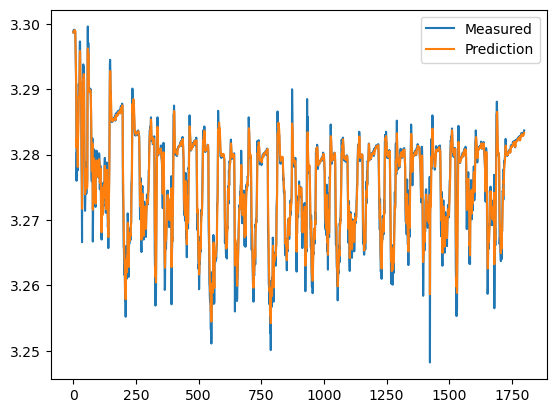

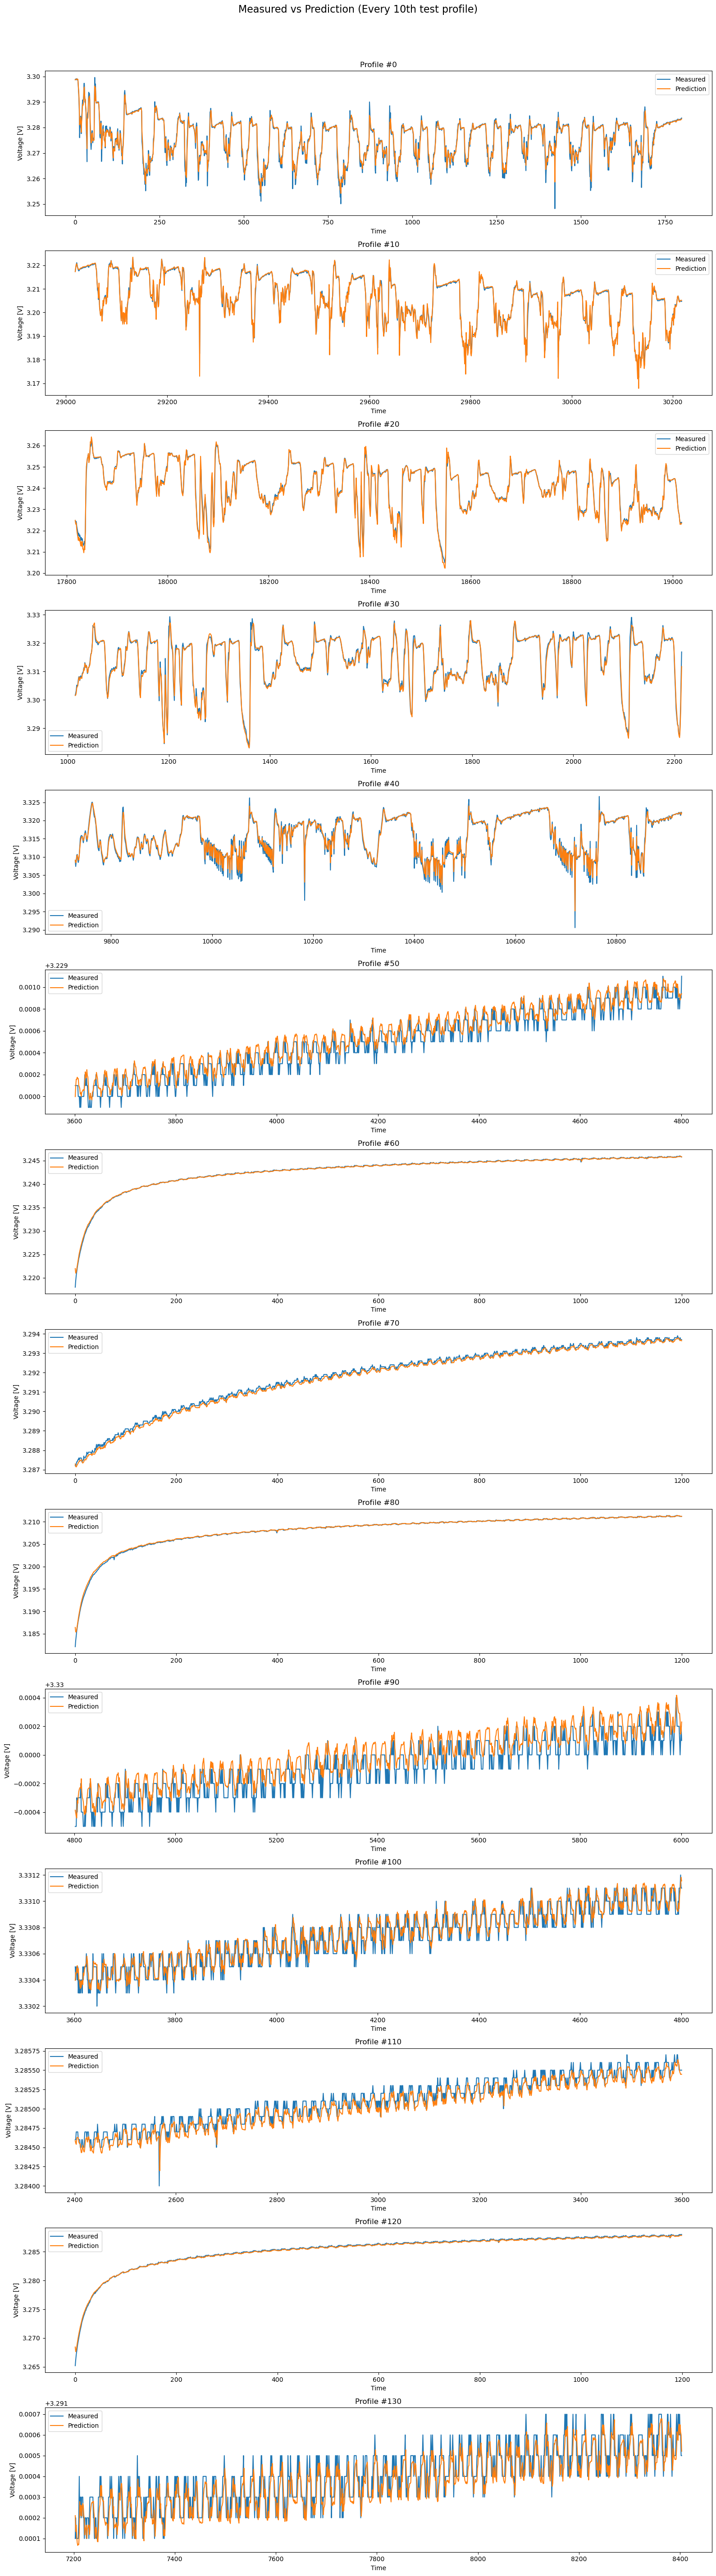

In [12]:
# 첫 번째 테스트 프로파일의 Vcorr 예측값 꺼내기
first_profile = test_dict_list[0]
vcorr_pred = first_profile['Vcorr_pred']        # denormalized
vcorr_pred_norm = first_profile['Vcorr_pred_norm']  # normalized

# 시간축과 함께 사용하기
time = first_profile['time']
V_meas = first_profile['V_meas']
V_spme = first_profile['V_spme']

# 플롯 예시
import matplotlib.pyplot as plt
plt.plot(time, V_meas, label='Measured')
plt.plot(time, V_spme + vcorr_pred, label='Prediction')
plt.legend()
plt.show()

# 여러 프로파일의 예측 vs 측정 플롯 (10번째 간격으로 ~16개)

import matplotlib.pyplot as plt

n_profiles = len(test_dict_list)
step = 10
selected_indices = list(range(0, n_profiles, step))

plt.figure(figsize=(16, 32 // 8 * len(selected_indices)))  # 높이 자동 조절

for i, idx in enumerate(selected_indices):
    d = test_dict_list[idx]
    time = d['time']
    V_meas = d['V_meas']
    V_spme = d['V_spme']
    vcorr_pred = d['Vcorr_pred']
    
    plt.subplot(len(selected_indices), 1, i + 1)
    plt.plot(time, V_meas, label='Measured')
    plt.plot(time, V_spme + vcorr_pred, label='Prediction')
    plt.title(f'Profile #{idx}')
    plt.xlabel('Time')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Measured vs Prediction (Every 10th test profile)', y=1.02, fontsize=16)
plt.show()
